# **Import**

## **Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import neighbors
from scipy.stats import zscore
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
import time

import warnings
warnings.filterwarnings('ignore')

## **Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/DISSERTATION/housing.csv")

# **Exploratory Data Analysis**

## **Data**

### **Data Head**

In [ ]:
data.head()

,id,url,region,region_url,price,type,sqfeet,beds,baths,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options,image_url,description,lat,long,state
0,7039061606,https://bham.craigslist.org/apa/d/birmingham-h...,birmingham,https://bham.craigslist.org,1195,apartment,1908,3,2.0,1,1,1,0,0,0,laundry on site,street parking,https://images.craigslist.org/00L0L_80pNkyDeG0...,Apartments In Birmingham AL Welcome to 100 Inv...,33.4226,-86.7065,al
1,7041970863,https://bham.craigslist.org/apa/d/birmingham-w...,birmingham,https://bham.craigslist.org,1120,apartment,1319,3,2.0,1,1,1,0,0,0,laundry on site,off-street parking,https://images.craigslist.org/00707_uRrY9CsNMC...,Find Your Way to Haven Apartment Homes Come ho...,33.3755,-86.8045,al
2,7041966914,https://bham.craigslist.org/apa/d/birmingham-g...,birmingham,https://bham.craigslist.org,825,apartment,1133,1,1.5,1,1,1,0,0,0,laundry on site,street parking,https://images.craigslist.org/00h0h_b7Bdj1NLBi...,Apartments In Birmingham AL Welcome to 100 Inv...,33.4226,-86.7065,al
3,7041966936,https://bham.craigslist.org/apa/d/birmingham-f...,birmingham,https://bham.craigslist.org,800,apartment,927,1,1.0,1,1,1,0,0,0,laundry on site,street parking,https://images.craigslist.org/00808_6ghZ8tSRQs...,Apartments In Birmingham AL Welcome to 100 Inv...,33.4226,-86.7065,al
4,7041966888,https://bham.craigslist.org/apa/d/birmingham-2...,birmingham,https://bham.craigslist.org,785,apartment,1047,2,1.0,1,1,1,0,0,0,laundry on site,street parking,https://images.craigslist.org/00y0y_21c0FOvUXm...,Apartments In Birmingham AL Welcome to 100 Inv...,33.4226,-86.7065,al


### **Data Shape**

In [ ]:
print("Data Shape : ", data.shape)
print("Number of Rows : ", data.shape[0])
print("Number of Columns : ", data.shape[1])

Data Shape :  (265190, 22)
Number of Rows :  265190
Number of Columns :  22


### **Data Columns**

In [ ]:
list(data.columns)

['id',
 'url',
 'region',
 'region_url',
 'price',
 'type',
 'sqfeet',
 'beds',
 'baths',
 'cats_allowed',
 'dogs_allowed',
 'smoking_allowed',
 'wheelchair_access',
 'electric_vehicle_charge',
 'comes_furnished',
 'laundry_options',
 'parking_options',
 'image_url',
 'description',
 'lat',
 'long',
 'state']

### **Data Column Types**

In [ ]:
data.dtypes

id                           int64
url                         object
region                      object
region_url                  object
price                        int64
type                        object
sqfeet                       int64
beds                         int64
baths                      float64
cats_allowed                 int64
dogs_allowed                 int64
smoking_allowed              int64
wheelchair_access            int64
electric_vehicle_charge      int64
comes_furnished              int64
laundry_options             object
parking_options             object
image_url                   object
description                 object
lat                        float64
long                       float64
state                       object
dtype: object

### **Data Description**

**Numerical Columns**

In [ ]:
data.describe()

,id,price,sqfeet,beds,baths,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,lat,long
count,2.651900e+05,2.651900e+05,2.651900e+05,265190.000000,265190.000000,265190.000000,265190.000000,265190.000000,265190.000000,265190.000000,265190.000000,263771.000000,263771.000000
mean,7.040888e+09,1.227285e+04,1.093678e+03,1.912414,1.483468,0.716822,0.696550,0.733896,0.078759,0.014360,0.048644,37.208855,-92.398149
std,8.778930e+06,5.376352e+06,2.306888e+04,3.691900,0.630208,0.450543,0.459749,0.441920,0.269362,0.118968,0.215124,5.659648,17.370780
min,7.003808e+09,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-43.533300,-163.894000
25%,7.035963e+09,8.170000e+02,7.520000e+02,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.508500,-104.704000
50%,7.043109e+09,1.060000e+03,9.500000e+02,2.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,37.984900,-86.478300
75%,7.048362e+09,1.450000e+03,1.156000e+03,2.000000,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,41.168400,-81.284600
max,7.051263e+09,2.768307e+09,8.388607e+06,1100.000000,75.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,102.036000,172.633000


**Text Columns**

In [ ]:
data.describe(include= "object")

,url,region,region_url,type,laundry_options,parking_options,image_url,description,state
count,265190,265190,265190,265190,210879,170055,265190,265188,265189
unique,265190,298,305,12,5,7,125141,195471,38
top,https://cincinnati.craigslist.org/apa/d/cincin...,jacksonville,https://omaha.craigslist.org,apartment,w/d in unit,off-street parking,https://images.craigslist.org/00R0R_ciYsssEFRe...,**New Management | Newly Renovated** Securi...,ca
freq,1,4246,2727,218032,91074,88316,406,503,33085


## **Missing Values**

### **Missing Value Detection**

In [ ]:
def detect_missing_values(data_frame):
  missing_value_details = (data_frame.isnull().sum()/len(data_frame)*100).sort_values(ascending=False)
  return missing_value_details

In [ ]:
detect_missing_values(data)

parking_options            35.874279
laundry_options            20.480033
lat                         0.535088
long                        0.535088
description                 0.000754
state                       0.000377
beds                        0.000000
url                         0.000000
region                      0.000000
region_url                  0.000000
price                       0.000000
type                        0.000000
sqfeet                      0.000000
dogs_allowed                0.000000
baths                       0.000000
cats_allowed                0.000000
smoking_allowed             0.000000
wheelchair_access           0.000000
electric_vehicle_charge     0.000000
comes_furnished             0.000000
image_url                   0.000000
id                          0.000000
dtype: float64

### **Missing Value Imputation**

**"lat"**, **"long"**, **"description"**, **"state"** columns are having negligible percentage of missing values. Hence the missing data can be dropped

In [ ]:
dropna_from_columns = ['lat', 'long', 'description', 'state']

In [ ]:
data = data.dropna(subset = dropna_from_columns)
data = data.reset_index(drop = True)

In [ ]:
data.shape

(263769, 22)

In [ ]:
data.tail(2)

,id,url,region,region_url,price,type,sqfeet,beds,baths,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options,image_url,description,lat,long,state
263767,7044801015,https://columbus.craigslist.org/apa/d/columbus...,columbus,https://columbus.craigslist.org,1507,apartment,1660,2,1.5,1,1,1,0,0,0,NaN,NaN,https://images.craigslist.org/00j0j_5EIRWzdHCV...,"The Commons at Olentangy4765 Blairfield Dr, Co...",40.0564,-83.0417,oh
263768,7050885800,https://columbus.craigslist.org/apa/d/newark-l...,columbus,https://columbus.craigslist.org,1001,apartment,1220,3,1.5,1,1,1,0,0,0,w/d hookups,off-street parking,https://images.craigslist.org/00J0J_6VSTqFJb86...,www.McMillenWoods.com www.mcmillenwoods.com ...,40.0451,-82.4564,oh


In [ ]:
detect_missing_values(data)

parking_options            35.805193
laundry_options            20.520228
state                       0.000000
cats_allowed                0.000000
url                         0.000000
region                      0.000000
region_url                  0.000000
price                       0.000000
type                        0.000000
sqfeet                      0.000000
beds                        0.000000
baths                       0.000000
dogs_allowed                0.000000
long                        0.000000
smoking_allowed             0.000000
wheelchair_access           0.000000
electric_vehicle_charge     0.000000
comes_furnished             0.000000
image_url                   0.000000
description                 0.000000
lat                         0.000000
id                          0.000000
dtype: float64

Missing data in **"parking_options"** and **"laundry_options"** will be filled with the mode of respective columns when grouped by the **"type"** of the house.

In [ ]:
def mode_wrt_type(data_frame, column_name):
  mode_df = data_frame.groupby(['type'])[column_name].agg(pd.Series.mode).to_frame()
  return mode_df

In [ ]:
def impute_mv_type_mode(data_frame, mode_data_frame):
  for i in list(mode_data_frame.index):
    data_frame_type_i = data_frame[data_frame["type"] == i]
    for j in list(data_frame_type_i[data_frame_type_i[list(mode_data_frame.columns)[0]].isnull()].index):
      data_frame[list(mode_data_frame.columns)[0]].iloc[j] = mode_data_frame.loc[i][0]
  return data_frame

**Parking Options**

In [ ]:
mode_type_parking = mode_wrt_type(data, "parking_options")
mode_type_parking

,parking_options
type,
apartment,off-street parking
assisted living,off-street parking
condo,off-street parking
cottage/cabin,off-street parking
duplex,off-street parking
flat,attached garage
house,attached garage
in-law,off-street parking
land,off-street parking


In [ ]:
data = impute_mv_type_mode(data, mode_type_parking)

In [ ]:
detect_missing_values(data)

laundry_options            20.520228
state                       0.000000
cats_allowed                0.000000
url                         0.000000
region                      0.000000
region_url                  0.000000
price                       0.000000
type                        0.000000
sqfeet                      0.000000
beds                        0.000000
baths                       0.000000
dogs_allowed                0.000000
long                        0.000000
smoking_allowed             0.000000
wheelchair_access           0.000000
electric_vehicle_charge     0.000000
comes_furnished             0.000000
parking_options             0.000000
image_url                   0.000000
description                 0.000000
lat                         0.000000
id                          0.000000
dtype: float64

**Laundry Options**

In [ ]:
mode_type_laundry = mode_wrt_type(data, "laundry_options")
mode_type_laundry

,laundry_options
type,
apartment,w/d in unit
assisted living,laundry on site
condo,w/d in unit
cottage/cabin,w/d in unit
duplex,w/d hookups
flat,w/d in unit
house,w/d hookups
in-law,w/d in unit
land,laundry on site


In [ ]:
data = impute_mv_type_mode(data, mode_type_laundry)

In [ ]:
detect_missing_values(data)

state                      0.0
long                       0.0
url                        0.0
region                     0.0
region_url                 0.0
price                      0.0
type                       0.0
sqfeet                     0.0
beds                       0.0
baths                      0.0
cats_allowed               0.0
dogs_allowed               0.0
smoking_allowed            0.0
wheelchair_access          0.0
electric_vehicle_charge    0.0
comes_furnished            0.0
laundry_options            0.0
parking_options            0.0
image_url                  0.0
description                0.0
lat                        0.0
id                         0.0
dtype: float64

**All the missing values are imputed.**

In [ ]:
data.shape

NameError: ignored

In [ ]:
data.tail(2)

,id,url,region,region_url,price,type,sqfeet,beds,baths,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options,image_url,description,lat,long,state
263767,7044801015,https://columbus.craigslist.org/apa/d/columbus...,columbus,https://columbus.craigslist.org,1507,apartment,1660,2,1.5,1,1,1,0,0,0,w/d in unit,off-street parking,https://images.craigslist.org/00j0j_5EIRWzdHCV...,"The Commons at Olentangy4765 Blairfield Dr, Co...",40.0564,-83.0417,oh
263768,7050885800,https://columbus.craigslist.org/apa/d/newark-l...,columbus,https://columbus.craigslist.org,1001,apartment,1220,3,1.5,1,1,1,0,0,0,w/d hookups,off-street parking,https://images.craigslist.org/00J0J_6VSTqFJb86...,www.McMillenWoods.com www.mcmillenwoods.com ...,40.0451,-82.4564,oh


**There are no missing indexes as length of data frame matches the rows in the data shape.**

## **Outliers**

### **Outlier Detection - Plot (Boxplot)**

In [ ]:
def detect_plot_outliers(data_frame, column_name):
  plt.hist(data_frame[column_name])
  fig = plt.figure(figsize =(10, 7))
  plt.show()

### **Outlier Treatment (IQR)**

In [ ]:
def remove_outlier_interquartile(data_frame, column_name):
  Q_1 = data_frame[column_name].quantile(0.25)
  Q_3 = data_frame[column_name].quantile(0.75)
  IQR = Q_3 - Q_1
  Lower_boundary  = Q_1 - (1.5 * IQR)
  Upper_boundary = Q_3 + (1.5 * IQR)
  Req_df = data_frame.loc[(data_frame[column_name] > Lower_boundary) & (data_frame[column_name] < Upper_boundary)]
  Req_df = Req_df.reset_index(drop=True)
  return Req_df

### **Outlier Detection and Treatment - Columns**

**Price**

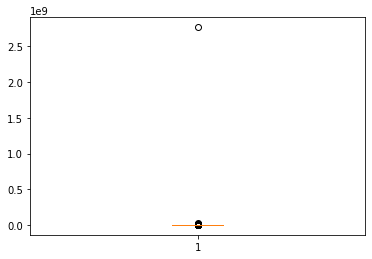

<Figure size 720x504 with 0 Axes>

In [ ]:
detect_plot_outliers(data, "price")

In [ ]:
data = remove_outlier_interquartile(data, "price")

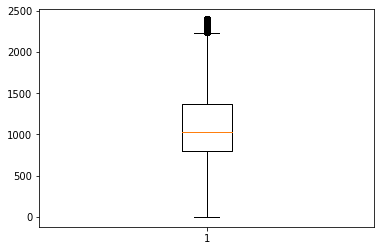

<Figure size 720x504 with 0 Axes>

In [ ]:
detect_plot_outliers(data, "price")

**Square Feet**

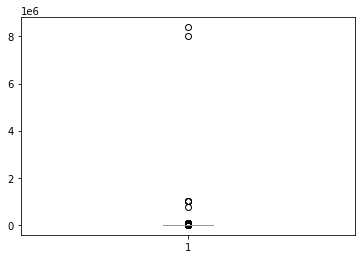

<Figure size 720x504 with 0 Axes>

In [ ]:
detect_plot_outliers(data, "sqfeet")

In [ ]:
data = remove_outlier_interquartile(data, "sqfeet")

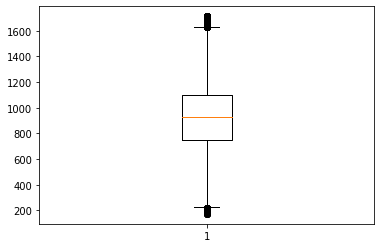

<Figure size 720x504 with 0 Axes>

In [ ]:
detect_plot_outliers(data, "sqfeet")

**Beds**

In [ ]:
print("Unique values in the column 'beds' :", set(data["beds"]))

Unique values in the column 'beds' : {0, 1, 2, 3, 4, 5, 6, 8}


**Baths**

In [ ]:
print("Unique values in the column 'baths' :", set(data["baths"]))

Unique values in the column 'baths' : {0.0, 1.5, 2.0, 2.5, 1.0, 3.0, 3.5, 4.5, 4.0, 5.0, 8.0}


The detection and treatment for outliers in the columns **'beds'** and **'baths'** will be not much useful as the count of unique values are less.

In [ ]:
data.shape

(241339, 22)

In [ ]:
data.tail(2)

,id,url,region,region_url,price,type,sqfeet,beds,baths,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options,image_url,description,lat,long,state
241337,7044801015,https://columbus.craigslist.org/apa/d/columbus...,columbus,https://columbus.craigslist.org,1507,apartment,1660,2,1.5,1,1,1,0,0,0,w/d in unit,off-street parking,https://images.craigslist.org/00j0j_5EIRWzdHCV...,"The Commons at Olentangy4765 Blairfield Dr, Co...",40.0564,-83.0417,oh
241338,7050885800,https://columbus.craigslist.org/apa/d/newark-l...,columbus,https://columbus.craigslist.org,1001,apartment,1220,3,1.5,1,1,1,0,0,0,w/d hookups,off-street parking,https://images.craigslist.org/00J0J_6VSTqFJb86...,www.McMillenWoods.com www.mcmillenwoods.com ...,40.0451,-82.4564,oh


**There are no missing indices as length of data frame matches the rows in the data shape.**

## **Feature Engineering and Selection**

### **Columns : "state" , "region"**

Both the columns **"state"** and **"region"** are categorical in type. For analysing the categorical columns, **chi-square analysis** method is approached

In [ ]:
CrosstabResult=pd.crosstab(index=data['state'],columns=data['region'])
print(CrosstabResult)

region  SF bay area  akron / canton  ...  yuma  zanesville / cambridge
state                                ...                              
ak                0               0  ...     0                       0
al                0               0  ...     0                       0
ar                0               0  ...     0                       0
az                0               0  ...   204                       0
ca              738               0  ...     0                       0
co                0               0  ...     0                       0
ct                0               0  ...     0                       0
dc                0               0  ...     0                       0
de                0               0  ...     0                       0
fl                0               0  ...     0                       0
ga                0               0  ...     0                       0
hi                0               0  ...     0                       0
ia    

In [ ]:
ChiSqResult = chi2_contingency(CrosstabResult)
print('The P-Value of the ChiSq Test is:', ChiSqResult[1])

The P-Value of the ChiSq Test is: 0.0


Two categorical variables are said to be correlated, if the P-value comes very close to zero. (if p > 0.05, the variables can be assumed not correlated)

The p-value for the chi-square analysis of 'state' and 'region' is 0. Hence both the columns are highly correlated.

In [ ]:
print("Count of unique values in the column 'region' :", len(set(data["region"])))

Count of unique values in the column 'region' : 298


In [ ]:
print("Count of unique values in the column 'state' :", len(set(data["state"])))

Count of unique values in the column 'state' : 38


Hence dropping the 'state' column which is having less number of unique values to retrive more information in predicting the 'price'

### **Columns : "id" , "url" , "region_url" , "image_url" , "description"**

Columns like 'id', 'url', 'region_url', 'image_url', 'description' are demographic data and these columns can be removed. 

### **Columns : "lat" , "long"**

Columns 'lat' and 'long' are referring to the region and hence these columns are removed.

### **Columns to drop**

In [ ]:
drop_columns = ["id", "url", "region_url", "image_url", "description", "lat", "long", "state"]

In [ ]:
main_data = data.drop(columns= drop_columns, axis = 1)

In [ ]:
main_data.head()

,region,price,type,sqfeet,beds,baths,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options
0,birmingham,1120,apartment,1319,3,2.0,1,1,1,0,0,0,laundry on site,off-street parking
1,birmingham,825,apartment,1133,1,1.5,1,1,1,0,0,0,laundry on site,street parking
2,birmingham,800,apartment,927,1,1.0,1,1,1,0,0,0,laundry on site,street parking
3,birmingham,785,apartment,1047,2,1.0,1,1,1,0,0,0,laundry on site,street parking
4,birmingham,900,apartment,1298,2,2.0,1,1,1,0,0,0,laundry on site,street parking


### **Converting Data types**

In [ ]:
main_data.dtypes

region                      object
price                        int64
type                        object
sqfeet                       int64
beds                         int64
baths                      float64
cats_allowed                 int64
dogs_allowed                 int64
smoking_allowed              int64
wheelchair_access            int64
electric_vehicle_charge      int64
comes_furnished              int64
laundry_options             object
parking_options             object
dtype: object

In [ ]:
category_columns = ["region", "type", "cats_allowed", "dogs_allowed", "smoking_allowed", "wheelchair_access", "electric_vehicle_charge", "comes_furnished", "laundry_options", "parking_options"]

In [ ]:
for col in category_columns:
  main_data[col] = main_data[col].astype('category')

In [ ]:
main_data.dtypes

region                     category
price                         int64
type                       category
sqfeet                        int64
beds                          int64
baths                       float64
cats_allowed               category
dogs_allowed               category
smoking_allowed            category
wheelchair_access          category
electric_vehicle_charge    category
comes_furnished            category
laundry_options            category
parking_options            category
dtype: object

In [ ]:
main_data.head()

,region,price,type,sqfeet,beds,baths,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options
0,birmingham,1120,apartment,1319,3,2.0,1,1,1,0,0,0,laundry on site,off-street parking
1,birmingham,825,apartment,1133,1,1.5,1,1,1,0,0,0,laundry on site,street parking
2,birmingham,800,apartment,927,1,1.0,1,1,1,0,0,0,laundry on site,street parking
3,birmingham,785,apartment,1047,2,1.0,1,1,1,0,0,0,laundry on site,street parking
4,birmingham,900,apartment,1298,2,2.0,1,1,1,0,0,0,laundry on site,street parking


### **Column - Analysis**

**Numerical data - Histogram Plot**

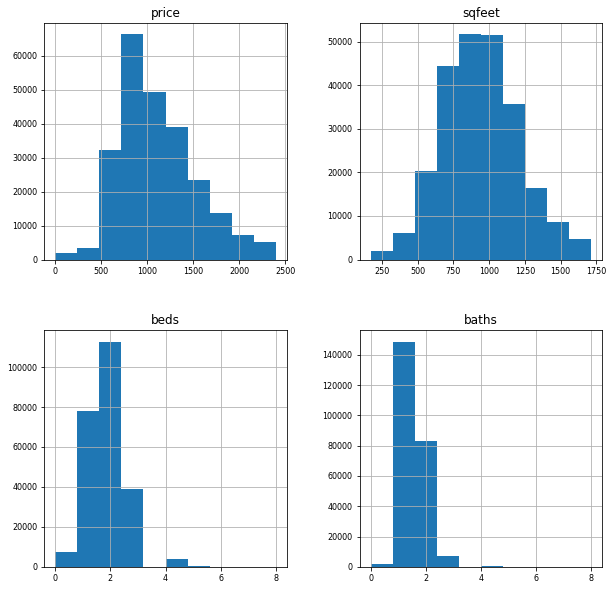

In [ ]:
main_data.hist(figsize=(10, 10),xlabelsize=8, ylabelsize=8);

**Correlation Analysis**

Correlation

In [ ]:
main_data.corr()

,price,sqfeet,beds,baths
price,1.000000,0.270243,0.108327,0.188090
sqfeet,0.270243,1.000000,0.776703,0.648779
beds,0.108327,0.776703,1.000000,0.612520
baths,0.188090,0.648779,0.612520,1.000000


**Correlation - Plots**

Heatmap

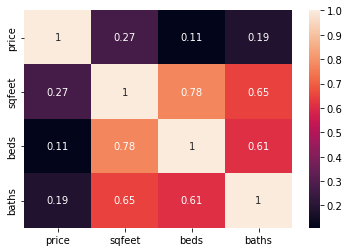

In [ ]:
sns.heatmap(main_data.corr(), annot=True)

Correlation between columns

In [ ]:
def cor_cols(column_1, column_2):
  cor_score = main_data.corr()[column_1].loc[column_2]
  return cor_score

In [ ]:
def plot_cor_cols(column_1, column_2):
  sns.jointplot(main_data[column_1], main_data[column_2])

In [ ]:
def cor_analysis(column_1, column_2):
  print("Correlation between ", column_1, " and ", column_2, " : ", cor_cols(column_1, column_2))
  plot_cor_cols(column_1, column_2)

Correlation :  'price' and 'sqfeet'

Correlation between  price  and  sqfeet  :  0.2702432902966533


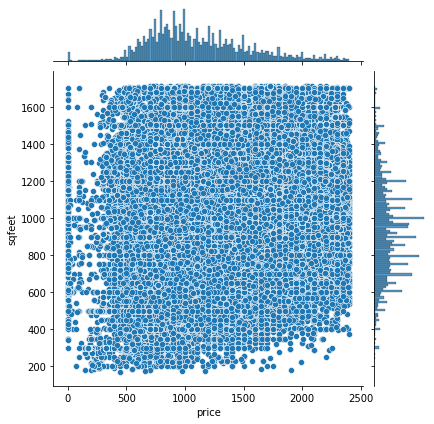

In [ ]:
col_1 = "price"
col_2 = "sqfeet"

cor_analysis(col_1, col_2)

Correlation : 'price' and 'beds'

Correlation between  price  and  beds  :  0.10832718575369936


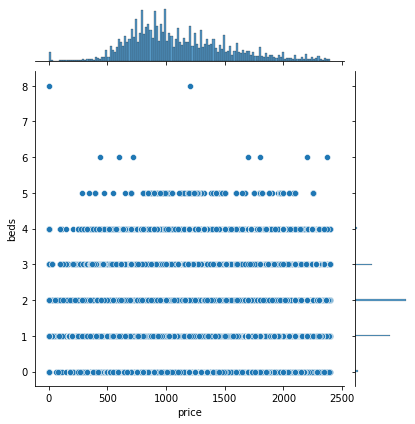

In [ ]:
col_1 = "price"
col_2 = "beds"

cor_analysis(col_1, col_2)

Correlation : 'price' and 'baths'

Correlation between  price  and  baths  :  0.1880899779524779


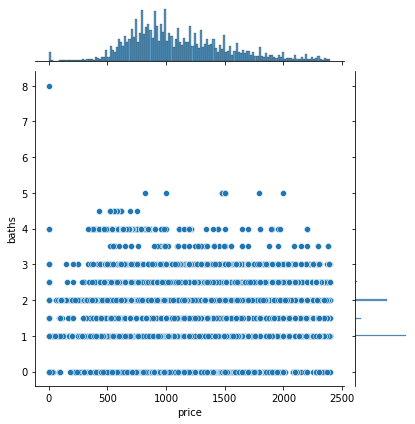

In [ ]:
col_1 = "price"
col_2 = "baths"

cor_analysis(col_1, col_2)

Correlation : 'beds' and 'sqfeet'

Correlation between  beds  and  sqfeet  :  0.7767026310537074


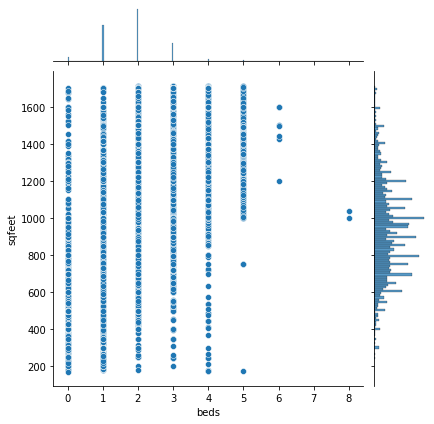

In [ ]:
col_1 = "beds"
col_2 = "sqfeet"

cor_analysis(col_1, col_2)

Correlation : 'baths' and 'beds'

Correlation between  beds  and  baths  :  0.6125195739388797


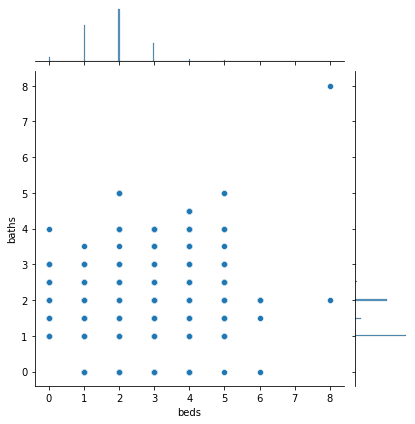

In [ ]:
col_1 = "beds"
col_2 = "baths"

cor_analysis(col_1, col_2)

Correlation : 'baths' and 'sqfeet'

Correlation between  sqfeet  and  baths  :  0.6487790635636984


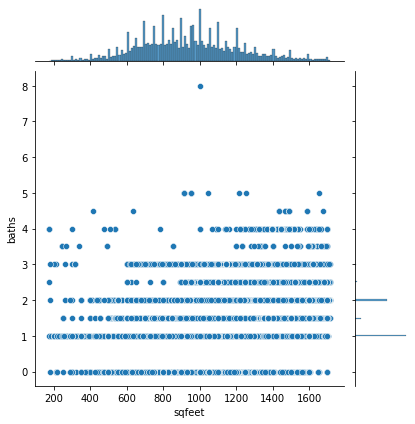

In [ ]:
col_1 = "sqfeet"
col_2 = "baths"

cor_analysis(col_1, col_2)

**Column Visualization**

Price

Text(0, 0.5, 'Frequency')

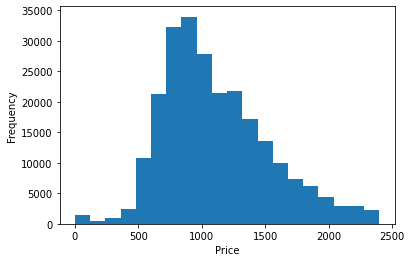

In [ ]:
plt.hist(main_data["price"], bins = 20)
plt.xlabel("Price")
plt.ylabel("Frequency")

Region

Text(0, 0.5, 'Frequency')

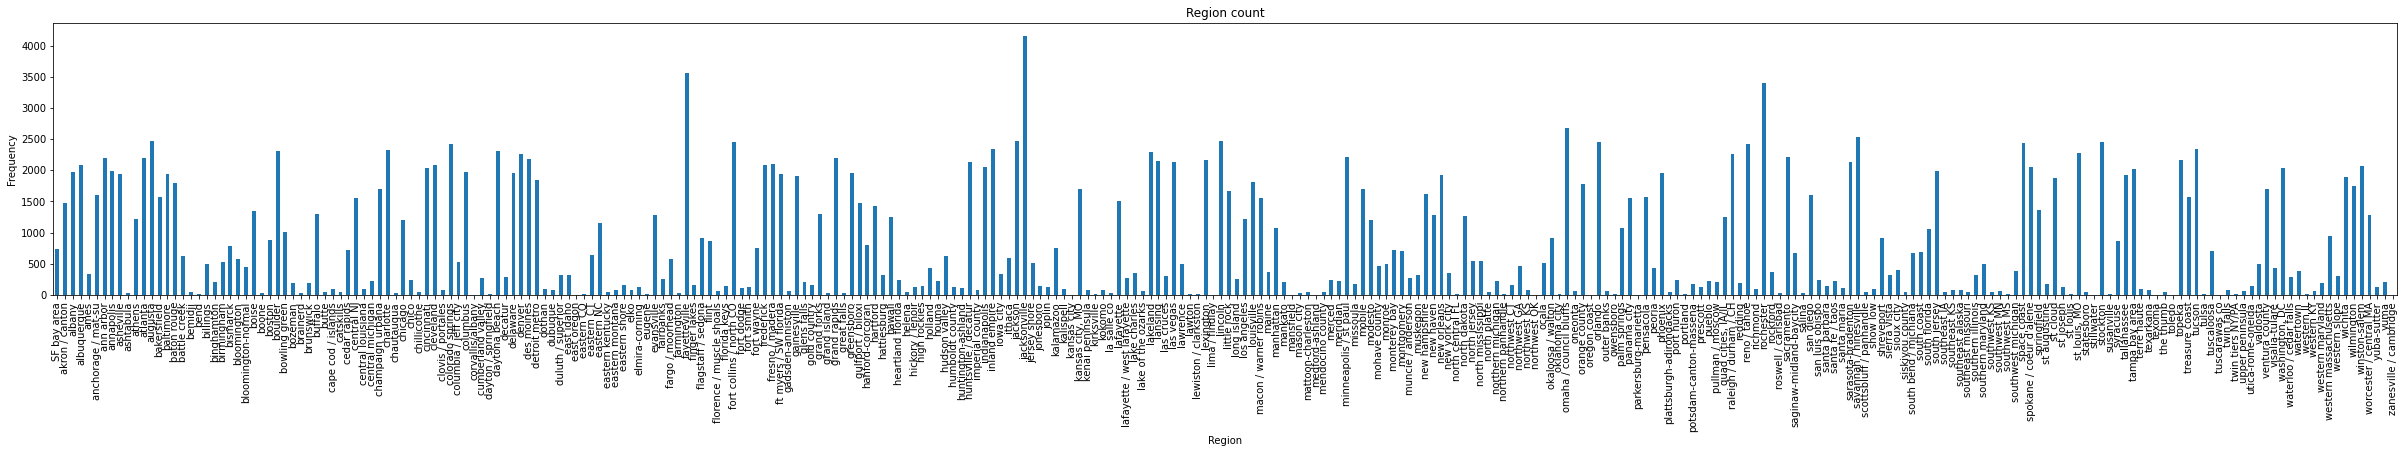

In [ ]:
Count = pd.value_counts(main_data['region'], sort = True).sort_index()
Count.plot(kind = 'bar', figsize=(42,5))
plt.title("Region count")
plt.xlabel("Region")
plt.ylabel("Frequency")

Type

Text(0, 0.5, 'Frequency')

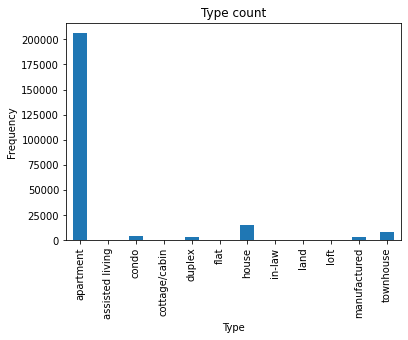

In [ ]:
Count = pd.value_counts(main_data['type'], sort = True).sort_index()
Count.plot(kind = 'bar')
plt.title("Type count")
plt.xlabel("Type")
plt.ylabel("Frequency")

Beds

Text(0, 0.5, 'Frequency')

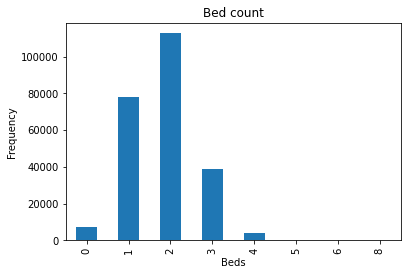

In [ ]:
Count = pd.value_counts(main_data['beds'], sort = True).sort_index()
Count.plot(kind = 'bar')
plt.title("Bed count")
plt.xlabel("Beds")
plt.ylabel("Frequency")

Baths

Text(0, 0.5, 'Frequency')

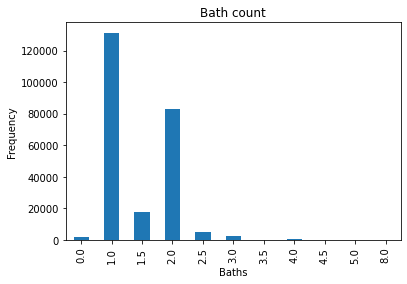

In [ ]:
Count = pd.value_counts(main_data['baths'], sort = True).sort_index()
Count.plot(kind = 'bar')
plt.title("Bath count")
plt.xlabel("Baths")
plt.ylabel("Frequency")

Cats Allowed

Text(0, 0.5, 'Frequency')

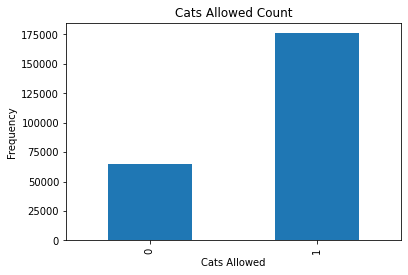

In [ ]:
Count = pd.value_counts(main_data['cats_allowed'], sort = True).sort_index()
Count.plot(kind = 'bar')
plt.title("Cats Allowed Count")
plt.xlabel("Cats Allowed")
plt.ylabel("Frequency")

Dogs Allowed

Text(0, 0.5, 'Frequency')

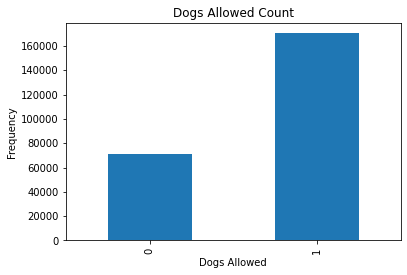

In [ ]:
Count = pd.value_counts(main_data['dogs_allowed'], sort = True).sort_index()
Count.plot(kind = 'bar')
plt.title("Dogs Allowed Count")
plt.xlabel("Dogs Allowed")
plt.ylabel("Frequency")

Smoking Allowed

Text(0, 0.5, 'Frequency')

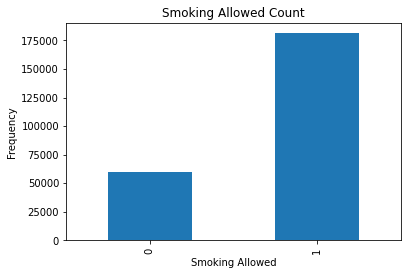

In [ ]:
Count = pd.value_counts(main_data['smoking_allowed'], sort = True).sort_index()
Count.plot(kind = 'bar')
plt.title("Smoking Allowed Count")
plt.xlabel("Smoking Allowed")
plt.ylabel("Frequency")

Wheel Chair Access

Text(0, 0.5, 'Frequency')

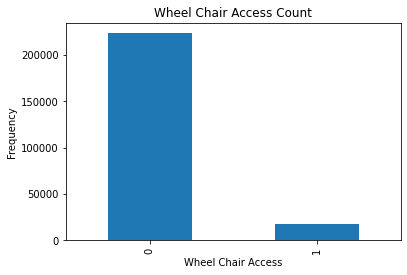

In [ ]:
Count = pd.value_counts(main_data['wheelchair_access'], sort = True).sort_index()
Count.plot(kind = 'bar')
plt.title("Wheel Chair Access Count")
plt.xlabel("Wheel Chair Access")
plt.ylabel("Frequency")

Electric Vehicle Charge

Text(0, 0.5, 'Frequency')

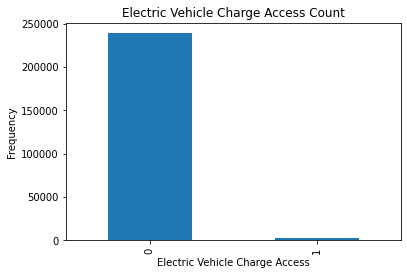

In [ ]:
Count = pd.value_counts(main_data['electric_vehicle_charge'], sort = True).sort_index()
Count.plot(kind = 'bar')
plt.title("Electric Vehicle Charge Access Count")
plt.xlabel("Electric Vehicle Charge Access")
plt.ylabel("Frequency")

Comes Furnished

Text(0, 0.5, 'Frequency')

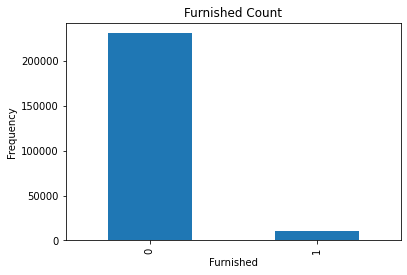

In [ ]:
Count = pd.value_counts(main_data['comes_furnished'], sort = True).sort_index()
Count.plot(kind = 'bar')
plt.title("Furnished Count")
plt.xlabel("Furnished")
plt.ylabel("Frequency")

Laundry Options

Text(0, 0.5, 'Frequency')

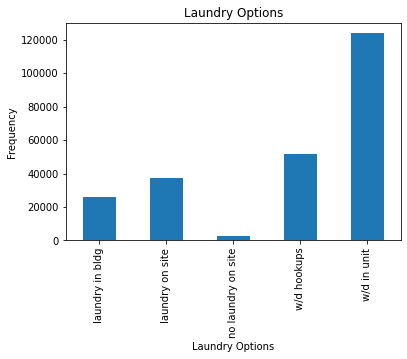

In [ ]:
Count = pd.value_counts(main_data['laundry_options'], sort = True).sort_index()
Count.plot(kind = 'bar')
plt.title("Laundry Options")
plt.xlabel("Laundry Options")
plt.ylabel("Frequency")

Parking Options

Text(0, 0.5, 'Frequency')

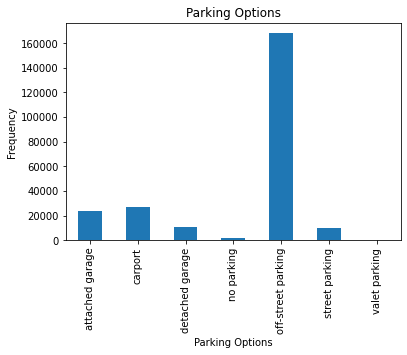

In [ ]:
Count = pd.value_counts(main_data['parking_options'], sort = True).sort_index()
Count.plot(kind = 'bar')
plt.title("Parking Options")
plt.xlabel("Parking Options")
plt.ylabel("Frequency")

**Price Analysis with categorical columns**

In [ ]:
def price_analysis(cat_column):
  temp_df = main_data.groupby([cat_column])["price"].agg(pd.Series.mean).to_frame()
  temp_df.reset_index(level=0, inplace=True)
  temp_df.plot(kind='bar',x=cat_column,y='price')

Price - Type

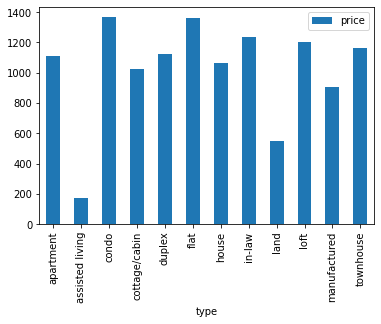

In [ ]:
price_analysis("type")

Price - Beds

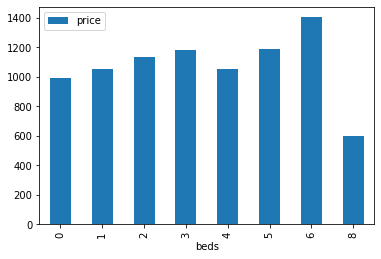

In [ ]:
price_analysis("beds")

Price - Baths

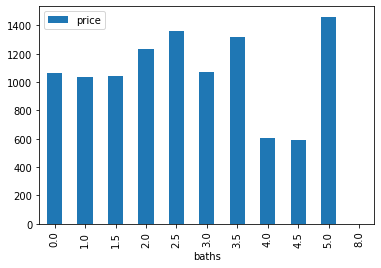

In [ ]:
price_analysis("baths")

Price - Cats Allowed

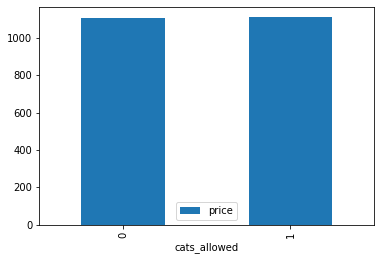

In [ ]:
price_analysis("cats_allowed")

Price - Dogs Allowed

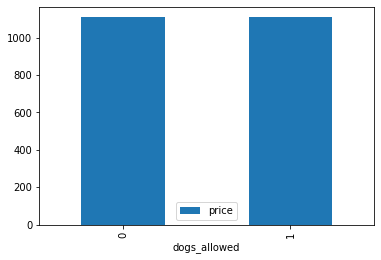

In [ ]:
price_analysis("dogs_allowed")

Price - Smoking Allowed

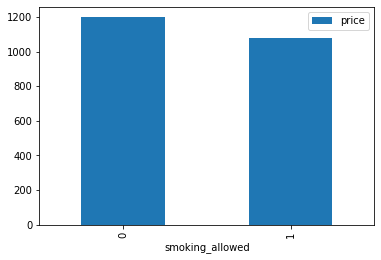

In [ ]:
price_analysis("smoking_allowed")

Price - Wheel Chair Access

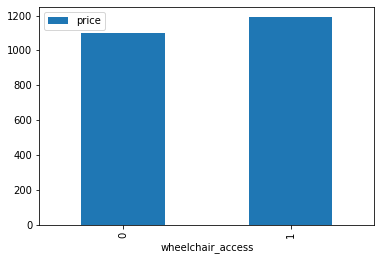

In [ ]:
price_analysis("wheelchair_access")

Price - Electric Vehicle Charge

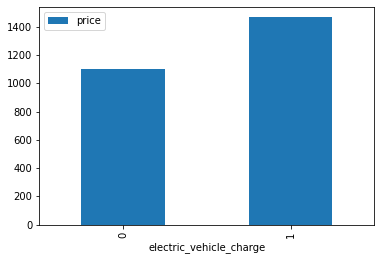

In [ ]:
price_analysis("electric_vehicle_charge")

Price - Comes Furnished

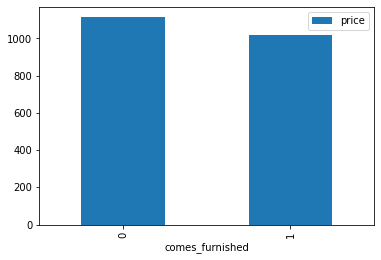

In [ ]:
price_analysis("comes_furnished")

Price _ Laundry Options

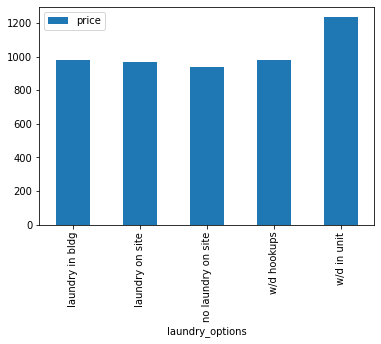

In [ ]:
price_analysis("laundry_options")

Price - Parking Options

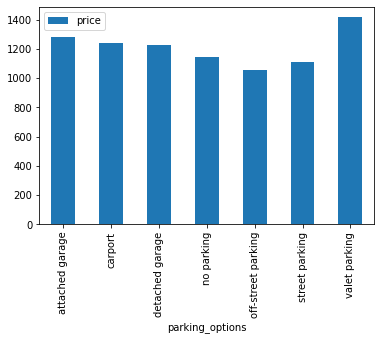

In [ ]:
price_analysis("parking_options")

### **Label Encoding the Text Categories**

In [ ]:
main_data.head()

,region,price,type,sqfeet,beds,baths,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options
0,birmingham,1120,apartment,1319,3,2.0,1,1,1,0,0,0,laundry on site,off-street parking
1,birmingham,825,apartment,1133,1,1.5,1,1,1,0,0,0,laundry on site,street parking
2,birmingham,800,apartment,927,1,1.0,1,1,1,0,0,0,laundry on site,street parking
3,birmingham,785,apartment,1047,2,1.0,1,1,1,0,0,0,laundry on site,street parking
4,birmingham,900,apartment,1298,2,2.0,1,1,1,0,0,0,laundry on site,street parking


In [ ]:
labelencoder_region = LabelEncoder()
main_data["region"] = labelencoder_region.fit_transform(main_data["region"])

labelencoder_type = LabelEncoder()
main_data["type"] = labelencoder_type.fit_transform(main_data["type"])

labelencoder_laundry = LabelEncoder()
main_data["laundry_options"] = labelencoder_laundry.fit_transform(main_data["laundry_options"])

labelencoder_parking = LabelEncoder()
main_data["parking_options"] = labelencoder_parking.fit_transform(main_data["parking_options"])

In [ ]:
main_data.head()

,region,price,type,sqfeet,beds,baths,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options
0,21,1120,0,1319,3,2.0,1,1,1,0,0,0,1,4
1,21,825,0,1133,1,1.5,1,1,1,0,0,0,1,5
2,21,800,0,927,1,1.0,1,1,1,0,0,0,1,5
3,21,785,0,1047,2,1.0,1,1,1,0,0,0,1,5
4,21,900,0,1298,2,2.0,1,1,1,0,0,0,1,5


Label encoding changes the data types of categories to Int. Hence converting the data types of required columns to category.

In [ ]:
main_data.dtypes

region                        int64
price                         int64
type                          int64
sqfeet                        int64
beds                          int64
baths                       float64
cats_allowed               category
dogs_allowed               category
smoking_allowed            category
wheelchair_access          category
electric_vehicle_charge    category
comes_furnished            category
laundry_options               int64
parking_options               int64
dtype: object

In [ ]:
for col in category_columns:
  main_data[col] = main_data[col].astype('category')

In [ ]:
main_data.dtypes

region                     category
price                         int64
type                       category
sqfeet                        int64
beds                          int64
baths                       float64
cats_allowed               category
dogs_allowed               category
smoking_allowed            category
wheelchair_access          category
electric_vehicle_charge    category
comes_furnished            category
laundry_options            category
parking_options            category
dtype: object

### **Mian Data Description**

In [ ]:
main_data.head()

,region,price,type,sqfeet,beds,baths,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options
0,21,1120,0,1319,3,2.0,1,1,1,0,0,0,1,4
1,21,825,0,1133,1,1.5,1,1,1,0,0,0,1,5
2,21,800,0,927,1,1.0,1,1,1,0,0,0,1,5
3,21,785,0,1047,2,1.0,1,1,1,0,0,0,1,5
4,21,900,0,1298,2,2.0,1,1,1,0,0,0,1,5


In [ ]:
main_data.tail()

,region,price,type,sqfeet,beds,baths,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options
241334,52,929,0,728,1,1.0,1,1,1,1,0,0,4,4
241335,52,0,0,1061,2,2.0,1,1,1,0,0,0,4,2
241336,52,1069,0,1020,2,1.5,1,1,1,0,0,0,3,2
241337,52,1507,0,1660,2,1.5,1,1,1,0,0,0,4,4
241338,52,1001,0,1220,3,1.5,1,1,1,0,0,0,3,4


In [ ]:
main_data.shape

(241339, 14)

Describe Numerical Columns

In [ ]:
main_data.describe()

,price,sqfeet,beds,baths
count,241339.000000,241339.000000,241339.000000,241339.000000
mean,1108.993068,939.605513,1.817004,1.430073
std,419.598677,269.435031,0.807855,0.544473
min,0.000000,172.000000,0.000000,0.000000
25%,800.000000,750.000000,1.000000,1.000000
50%,1020.000000,927.000000,2.000000,1.000000
75%,1357.000000,1102.000000,2.000000,2.000000
max,2397.000000,1714.000000,8.000000,8.000000


Describe Categorical Columns

In [ ]:
main_data.describe(include="category")

,region,type,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options
count,241339,241339,241339,241339,241339,241339,241339,241339,241339,241339
unique,298,12,2,2,2,2,2,2,5,7
top,123,0,1,1,1,0,0,0,4,4
freq,4153,206142,175976,170395,181168,223420,238723,231128,123798,168099


# **Data Split**

## **Assigning Independent Variables**

In [ ]:
X = main_data.drop(columns= "price", axis = 1)

In [ ]:
X.shape

(241339, 13)

In [ ]:
X.head()

,region,type,sqfeet,beds,baths,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options
0,21,0,1319,3,2.0,1,1,1,0,0,0,1,4
1,21,0,1133,1,1.5,1,1,1,0,0,0,1,5
2,21,0,927,1,1.0,1,1,1,0,0,0,1,5
3,21,0,1047,2,1.0,1,1,1,0,0,0,1,5
4,21,0,1298,2,2.0,1,1,1,0,0,0,1,5


## **Assigning Dependent Variable**

In [ ]:
y = main_data[["price"]]

In [ ]:
y.shape

(241339, 1)

In [ ]:
y.head()

,price
0,1120
1,825
2,800
3,785
4,900


## **Split Train and Test Data**

Splitting Train and Test data in the ratio **75:25**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)

In [ ]:
print("Shape of X_train : ", X_train.shape)
print("Shape of y_train : ", y_train.shape)
print("Shape of X_test : ", X_test.shape)
print("Shape of y_test : ", y_test.shape)

Shape of X_train :  (181004, 13)
Shape of y_train :  (181004, 1)
Shape of X_test :  (60335, 13)
Shape of y_test :  (60335, 1)


### **Applying Data Normalization for Distance based Models**

In [ ]:
X_train_z = X_train.apply(zscore)

In [ ]:
X_train_z.head()

,region,type,sqfeet,beds,baths,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options
194830,-1.102742,1.846792,2.391089,1.465033,1.965373,0.608206,0.644411,0.575989,-0.283017,-0.105702,4.745443,0.092955,-2.173066
49393,-0.909994,-0.374764,-0.060966,0.227000,0.129170,0.608206,0.644411,0.575989,-0.283017,-0.105702,-0.210728,-1.285875,0.529538
169928,-0.456469,-0.374764,-1.348203,-1.011034,-0.788931,0.608206,0.644411,-1.736143,-0.283017,-0.105702,-0.210728,0.782369,0.529538
238053,-1.046051,-0.374764,-0.702730,-1.011034,-0.788931,0.608206,0.644411,0.575989,-0.283017,-0.105702,-0.210728,-1.975289,0.529538
154607,-1.420209,-0.374764,-0.276124,0.227000,-0.788931,0.608206,-1.551804,0.575989,-0.283017,-0.105702,-0.210728,-1.285875,1.205189


In [ ]:
X_test_z = X_test.apply(zscore)

In [ ]:
X_test_z.head()

,region,type,sqfeet,beds,baths,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options
31319,0.851832,1.845270,-0.948297,0.225086,-0.792776,-1.630813,-1.543744,0.577255,-0.283756,-0.101563,-0.208559,0.089357,0.531264
167139,-0.889169,-0.373393,2.341330,0.225086,1.045190,0.613191,0.647776,0.577255,-0.283756,-0.101563,-0.208559,0.779139,0.531264
19745,-0.547796,-0.373393,-0.297806,0.225086,-0.792776,-1.630813,-1.543744,-1.732338,-0.283756,-0.101563,-0.208559,-1.290208,-1.496560
63256,-0.536417,-0.373393,1.348866,1.462385,1.045190,0.613191,0.647776,0.577255,-0.283756,-0.101563,-0.208559,0.779139,0.531264
167872,-0.638829,-0.373393,0.780151,-1.012212,-0.792776,0.613191,0.647776,0.577255,-0.283756,-0.101563,-0.208559,-1.979991,-1.496560


# **Model Building and Evaluation**

In [ ]:
model_df_columns = ["Model_Name", "Hyperparameters", "MAE", "MSE", "RMSE", "R2", "CV_R2"]

## **Linear Regression with Stochastic Gradient Descent**

In [ ]:
iter_loss = ["squared_error", "huber"]
iter_penalty = ["l2", "l1"]

In [ ]:
iter_loss = ["squared_error"] # iter_loss = ["squared_error", "huber"]
iter_penalty = ["l2", "l1"]
iter_alpha = [0.0001, 0.001, 0.01]

In [ ]:
LR_SGD_df = pd.DataFrame(columns=model_df_columns)
for i in iter_loss:
  for j in iter_penalty:
    for k in iter_alpha:
      start_time = time.time()
      SGDregressor = SGDRegressor(loss=i, penalty=j, alpha=k, random_state= 10)
      SGDregressor.fit(X_train_z, y_train)
      y_pred = SGDregressor.predict(X_test_z)
      CV_scores = cross_val_score(SGDregressor, X_train_z, y_train, scoring='r2', cv=10)
      CV_R2 = CV_scores.mean()
      hyperparam_tuple = ("loss = " + i, "penalty = " + j, "alpha = " + str(k))
      LR_SGD_df = LR_SGD_df.append({
          "Model_Name" : "Linear Regression SGD",
          "Hyperparameters" : hyperparam_tuple,
          "MAE"  :  metrics.mean_absolute_error(y_test, y_pred), 
          "MSE"  :  metrics.mean_squared_error(y_test, y_pred),
          "RMSE" :  np.sqrt(metrics.mean_squared_error(y_test, y_pred)),
          "R2"   :  r2_score(y_test, y_pred),
          "CV_R2":  CV_R2
      }, ignore_index=True)
      end_time = time.time()
      print("Executed hyperparameters : ", hyperparam_tuple, "; in time : ", end_time-start_time)

Executed hyperparameters :  ('loss = squared_error', 'penalty = l2', 'alpha = 0.0001') ; in time :  13.64095163345337
Executed hyperparameters :  ('loss = squared_error', 'penalty = l2', 'alpha = 0.001') ; in time :  14.830411434173584
Executed hyperparameters :  ('loss = squared_error', 'penalty = l2', 'alpha = 0.01') ; in time :  14.840925693511963
Executed hyperparameters :  ('loss = squared_error', 'penalty = l1', 'alpha = 0.0001') ; in time :  16.64535403251648
Executed hyperparameters :  ('loss = squared_error', 'penalty = l1', 'alpha = 0.001') ; in time :  15.387633323669434
Executed hyperparameters :  ('loss = squared_error', 'penalty = l1', 'alpha = 0.01') ; in time :  14.647345066070557


In [ ]:
LR_SGD_df

,Model_Name,Hyperparameters,MAE,MSE,RMSE,R2,CV_R2
0,Linear Regression SGD,"(loss = squared_error, penalty = l2, alpha = 0...",294.902466,144713.638905,380.412459,0.177875,0.180465
1,Linear Regression SGD,"(loss = squared_error, penalty = l2, alpha = 0...",294.914548,144713.170416,380.411843,0.177878,0.180467
2,Linear Regression SGD,"(loss = squared_error, penalty = l2, alpha = 0...",295.043917,144722.281804,380.423819,0.177826,0.180413
3,Linear Regression SGD,"(loss = squared_error, penalty = l1, alpha = 0...",294.900252,144713.233141,380.411926,0.177878,0.180467
4,Linear Regression SGD,"(loss = squared_error, penalty = l1, alpha = 0...",294.890836,144708.608041,380.405846,0.177904,0.180510
5,Linear Regression SGD,"(loss = squared_error, penalty = l1, alpha = 0...",294.854517,144688.628096,380.379584,0.178017,0.180456


## **DecisionTree Regression**

In [ ]:
iter_criterion = ["squared_error", "friedman_mse", "poisson"]
iter_max_features = ["auto", "sqrt", "log2"]

In [ ]:
DT_R_df = pd.DataFrame(columns=model_df_columns)
for i in iter_criterion:
  for j in iter_max_features:
    start_time = time.time()
    DT_regressor = DecisionTreeRegressor(criterion=i, max_features=j, random_state= 10)
    DT_regressor.fit(X_train, y_train)
    y_pred = DT_regressor.predict(X_test)
    CV_scores = cross_val_score(DT_regressor, X_train, y_train, scoring='r2', cv=10)
    CV_R2 = CV_scores.mean()
    hyperparam_tuple = ("criterion = " + i, "max_features = " + j)
    DT_R_df = DT_R_df.append({
        "Model_Name" : "DecisionTree Regression",
        "Hyperparameters" : hyperparam_tuple,
        "MAE"  :  metrics.mean_absolute_error(y_test, y_pred), 
        "MSE"  :  metrics.mean_squared_error(y_test, y_pred),
        "RMSE" :  np.sqrt(metrics.mean_squared_error(y_test, y_pred)),
        "R2"   :  r2_score(y_test, y_pred),
        "CV_R2":  CV_R2
    }, ignore_index=True)
    end_time = time.time()
    print("Executed hyperparameters : ", hyperparam_tuple, "; in time : ", end_time-start_time)

Executed hyperparameters :  ('criterion = squared_error', 'max_features = auto') ; in time :  8.936447381973267
Executed hyperparameters :  ('criterion = squared_error', 'max_features = sqrt') ; in time :  3.8191771507263184
Executed hyperparameters :  ('criterion = squared_error', 'max_features = log2') ; in time :  3.8740434646606445
Executed hyperparameters :  ('criterion = friedman_mse', 'max_features = auto') ; in time :  9.375882148742676
Executed hyperparameters :  ('criterion = friedman_mse', 'max_features = sqrt') ; in time :  3.803358316421509
Executed hyperparameters :  ('criterion = friedman_mse', 'max_features = log2') ; in time :  3.7245547771453857
Executed hyperparameters :  ('criterion = poisson', 'max_features = auto') ; in time :  27.558905363082886
Executed hyperparameters :  ('criterion = poisson', 'max_features = sqrt') ; in time :  9.347564697265625
Executed hyperparameters :  ('criterion = poisson', 'max_features = log2') ; in time :  9.285490036010742


In [ ]:
DT_R_df

,Model_Name,Hyperparameters,MAE,MSE,RMSE,R2,CV_R2
0,DecisionTree Regression,"(criterion = squared_error, max_features = auto)",87.135259,43355.624340,208.220134,0.753695,0.753889
1,DecisionTree Regression,"(criterion = squared_error, max_features = sqrt)",101.997808,58650.352632,242.178349,0.666805,0.657363
2,DecisionTree Regression,"(criterion = squared_error, max_features = log2)",101.997808,58650.352632,242.178349,0.666805,0.657363
3,DecisionTree Regression,"(criterion = friedman_mse, max_features = auto)",86.920292,43135.180792,207.690108,0.754947,0.755314
4,DecisionTree Regression,"(criterion = friedman_mse, max_features = sqrt)",103.621630,59509.235979,243.945150,0.661925,0.651141
5,DecisionTree Regression,"(criterion = friedman_mse, max_features = log2)",103.621630,59509.235979,243.945150,0.661925,0.651141
6,DecisionTree Regression,"(criterion = poisson, max_features = auto)",104.725260,60512.948941,245.993799,0.656223,0.633911
7,DecisionTree Regression,"(criterion = poisson, max_features = sqrt)",102.263249,57494.679442,239.780482,0.673370,0.660611
8,DecisionTree Regression,"(criterion = poisson, max_features = log2)",102.263249,57494.679442,239.780482,0.673370,0.660611


## **RandomForest Regression**

In [ ]:
iter_estimators = [50, 75, 100, 150]
iter_max_features = ["auto", "sqrt", "log2"]

In [ ]:
RF_R_df = pd.DataFrame(columns=model_df_columns)
for i in iter_estimators:
  for j in iter_max_features:
    start_time = time.time()
    rf_regressor = RandomForestRegressor(n_estimators=i, max_features=j, random_state= 10)
    rf_regressor.fit(X_train, y_train)
    y_pred = rf_regressor.predict(X_test)
    CV_scores = cross_val_score(rf_regressor, X_train, y_train, scoring='r2', cv=5)
    CV_R2 = CV_scores.mean()
    hyperparam_tuple = ("n_estimators = " + str(i), "max_features = " + j)
    RF_R_df = RF_R_df.append({
        "Model_Name" : "RandomForest Regression",
        "Hyperparameters" : hyperparam_tuple,
        "MAE"  :  metrics.mean_absolute_error(y_test, y_pred), 
        "MSE"  :  metrics.mean_squared_error(y_test, y_pred),
        "RMSE" :  np.sqrt(metrics.mean_squared_error(y_test, y_pred)),
        "R2"   :  r2_score(y_test, y_pred),
        "CV_R2":  CV_R2
    }, ignore_index=True)
    end_time = time.time()
    print("Executed hyperparameters : ", hyperparam_tuple, "; in time : ", end_time-start_time)

Executed hyperparameters :  ('n_estimators = 50', 'max_features = auto') ; in time :  143.1248471736908
Executed hyperparameters :  ('n_estimators = 50', 'max_features = sqrt') ; in time :  58.13687229156494
Executed hyperparameters :  ('n_estimators = 50', 'max_features = log2') ; in time :  59.0986762046814
Executed hyperparameters :  ('n_estimators = 75', 'max_features = auto') ; in time :  213.01482605934143
Executed hyperparameters :  ('n_estimators = 75', 'max_features = sqrt') ; in time :  86.00130224227905
Executed hyperparameters :  ('n_estimators = 75', 'max_features = log2') ; in time :  83.20949268341064
Executed hyperparameters :  ('n_estimators = 100', 'max_features = auto') ; in time :  282.0470995903015
Executed hyperparameters :  ('n_estimators = 100', 'max_features = sqrt') ; in time :  112.75898361206055
Executed hyperparameters :  ('n_estimators = 100', 'max_features = log2') ; in time :  112.98614120483398
Executed hyperparameters :  ('n_estimators = 150', 'max_fea

In [ ]:
RF_R_df

,Model_Name,Hyperparameters,MAE,MSE,RMSE,R2,CV_R2
0,RandomForest Regression,"(n_estimators = 50, max_features = auto)",77.368790,26610.283277,163.126587,0.848826,0.843483
1,RandomForest Regression,"(n_estimators = 50, max_features = sqrt)",89.599788,33944.772600,184.241072,0.807158,0.799778
2,RandomForest Regression,"(n_estimators = 50, max_features = log2)",89.599788,33944.772600,184.241072,0.807158,0.799778
3,RandomForest Regression,"(n_estimators = 75, max_features = auto)",77.174428,26532.487412,162.887960,0.849268,0.844548
4,RandomForest Regression,"(n_estimators = 75, max_features = sqrt)",89.461363,33832.994415,183.937474,0.807793,0.801074
5,RandomForest Regression,"(n_estimators = 75, max_features = log2)",89.461363,33832.994415,183.937474,0.807793,0.801074
6,RandomForest Regression,"(n_estimators = 100, max_features = auto)",77.024649,26439.635925,162.602693,0.849795,0.845070
7,RandomForest Regression,"(n_estimators = 100, max_features = sqrt)",89.221291,33699.429029,183.574042,0.808552,0.801856
8,RandomForest Regression,"(n_estimators = 100, max_features = log2)",89.221291,33699.429029,183.574042,0.808552,0.801856
9,RandomForest Regression,"(n_estimators = 150, max_features = auto)",76.944300,26359.942201,162.357452,0.850248,0.845385


## **KNN Regression**

In [ ]:
iter_neighbors = [3, 5, 6, 7, 10]

In [ ]:
KNN_R_df = pd.DataFrame(columns=model_df_columns)
for i in iter_neighbors:
  start_time = time.time()
  knn_regressor = neighbors.KNeighborsRegressor(n_neighbors = i)
  knn_regressor.fit(X_train_z, y_train)
  y_pred = knn_regressor.predict(X_test_z)
  CV_scores = cross_val_score(knn_regressor, X_train_z, y_train, scoring='r2', cv=5)
  CV_R2 = CV_scores.mean()
  hyperparam_tuple = ("n_neighbors = " + str(i))
  KNN_R_df = KNN_R_df.append({
      "Model_Name" : "KNN Regression",
      "Hyperparameters" : hyperparam_tuple,
      "MAE"  :  metrics.mean_absolute_error(y_test, y_pred), 
      "MSE"  :  metrics.mean_squared_error(y_test, y_pred),
      "RMSE" :  np.sqrt(metrics.mean_squared_error(y_test, y_pred)),
      "R2"   :  r2_score(y_test, y_pred),
      "CV_R2":  CV_R2
  }, ignore_index=True)
  end_time = time.time()
  print("Executed hyperparameters : ", hyperparam_tuple, "; in time : ", end_time-start_time)

Executed hyperparameters :  n_neighbors = 3 ; in time :  208.63191413879395
Executed hyperparameters :  n_neighbors = 5 ; in time :  228.35048151016235
Executed hyperparameters :  n_neighbors = 6 ; in time :  229.28283262252808
Executed hyperparameters :  n_neighbors = 7 ; in time :  231.4379391670227
Executed hyperparameters :  n_neighbors = 10 ; in time :  237.9616620540619


In [ ]:
KNN_R_df

,Model_Name,Hyperparameters,MAE,MSE,RMSE,R2,CV_R2
0,KNN Regression,n_neighbors = 3,119.736985,58869.433605,242.630240,0.665560,0.650280
1,KNN Regression,n_neighbors = 5,129.210700,61369.736154,247.729159,0.651356,0.635783
2,KNN Regression,n_neighbors = 6,133.464973,62769.440102,250.538301,0.643404,0.626916
3,KNN Regression,n_neighbors = 7,137.474269,64295.630697,253.565831,0.634734,0.618471
4,KNN Regression,n_neighbors = 10,148.363191,68960.911214,262.604096,0.608230,0.593306


# **Result Analysis**

In [ ]:
evaluation_dataframes = [LR_SGD_df, DT_R_df, RF_R_df, KNN_R_df]

In [ ]:
Main_DF = pd.concat(evaluation_dataframes)

In [ ]:
Main_DF = Main_DF.sort_values(by=["CV_R2"], ascending=False)

In [ ]:
Main_DF.reset_index(drop=True, inplace=True)
Main_DF

,Model_Name,Hyperparameters,MAE,MSE,RMSE,R2,CV_R2
0,RandomForest Regression,"(n_estimators = 150, max_features = auto)",76.944300,26359.942201,162.357452,0.850248,0.845385
1,RandomForest Regression,"(n_estimators = 100, max_features = auto)",77.024649,26439.635925,162.602693,0.849795,0.845070
2,RandomForest Regression,"(n_estimators = 75, max_features = auto)",77.174428,26532.487412,162.887960,0.849268,0.844548
3,RandomForest Regression,"(n_estimators = 50, max_features = auto)",77.368790,26610.283277,163.126587,0.848826,0.843483
4,RandomForest Regression,"(n_estimators = 150, max_features = sqrt)",89.156513,33633.657249,183.394812,0.808926,0.801959
5,RandomForest Regression,"(n_estimators = 150, max_features = log2)",89.156513,33633.657249,183.394812,0.808926,0.801959
6,RandomForest Regression,"(n_estimators = 100, max_features = log2)",89.221291,33699.429029,183.574042,0.808552,0.801856
7,RandomForest Regression,"(n_estimators = 100, max_features = sqrt)",89.221291,33699.429029,183.574042,0.808552,0.801856
8,RandomForest Regression,"(n_estimators = 75, max_features = log2)",89.461363,33832.994415,183.937474,0.807793,0.801074
9,RandomForest Regression,"(n_estimators = 75, max_features = sqrt)",89.461363,33832.994415,183.937474,0.807793,0.801074


In [ ]:
best_rf_regressor = RandomForestRegressor(n_estimators=150, max_features="auto", random_state= 10)

best_rf_regressor.fit(X_train, y_train)

y_pred = best_rf_regressor.predict(X_test)

print("R2 value : ", r2_score(y_test, y_pred)) 

R2 value :  0.8502479647328256


In [ ]:
best_model_output_comparision = pd.DataFrame()

In [ ]:
y_actual = y_test.reset_index(drop = True)
y_actual

,price
0,1200
1,1359
2,0
3,1750
4,1118
...,...
60330,1550
60331,1399
60332,1890
60333,2000


In [ ]:
best_model_output_comparision["Y - Actual"] = y_actual["price"]
best_model_output_comparision["Y - Predicted"] = y_pred
best_model_output_comparision.head(10)

,Y - Actual,Y - Predicted
0,1200,864.544444
1,1359,1453.638072
2,0,0.000000
3,1750,1663.570000
4,1118,1030.149259
5,1600,1875.000000
6,772,781.792049
7,1269,1268.874530
8,850,944.786673
9,735,735.000000


In [ ]:
best_model_output_comparision["Index"] = best_model_output_comparision.index[:] + 1

In [ ]:
best_model_output_comparision = best_model_output_comparision[["Index", "Y - Actual", "Y - Predicted"]]
best_model_output_comparision.head(10)

,Index,Y - Actual,Y - Predicted
0,1,1200,864.544444
1,2,1359,1453.638072
2,3,0,0.000000
3,4,1750,1663.570000
4,5,1118,1030.149259
5,6,1600,1875.000000
6,7,772,781.792049
7,8,1269,1268.874530
8,9,850,944.786673
9,10,735,735.000000


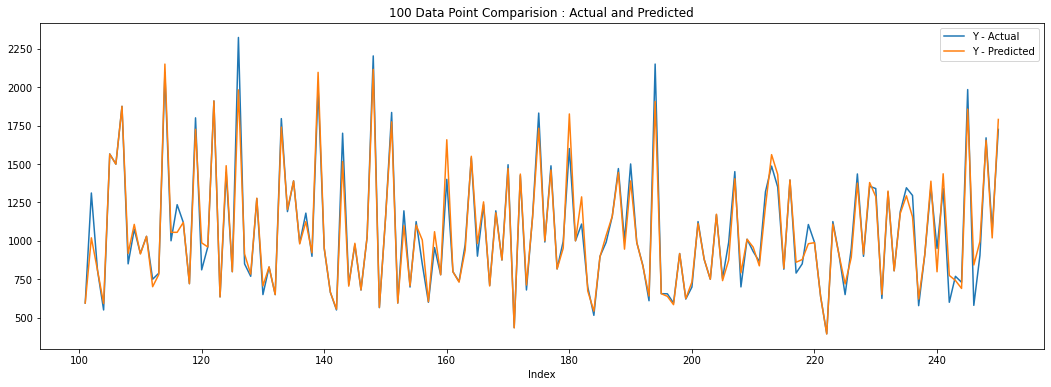

In [ ]:
best_model_output_comparision.iloc[100:250,:].plot(x="Index", y=["Y - Actual", "Y - Predicted"], figsize=(18, 6))
plt.title("100 Data Point Comparision : Actual and Predicted")
plt.show()